# Emergency vehicles detection

In [1]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'data\\train'
test_dir = 'data\\test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=16
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=16
)

C:\Users\bikas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 9410 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


# Defining custom metrix

In [2]:
from keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
                 
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [3]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 47,077,418
Trainable params: 47,022,890
Non-trainable params: 54,528
_________________________________________________________________


In [4]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=600, 
                              epochs=1, 
                              validation_data=test_generator,
                              validation_steps=25)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/1
196/600 [========>.....................] - ETA: 1:11 - loss: 0.4771 - categorical_accuracy: 0.89

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


551/600 [==========================>...] - ETA: 8s - loss: 0.3400 - categorical_accuracy: 0.9135

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


600/600 [==============================] - 106s 177ms/step - loss: 0.3312 - categorical_accuracy: 0.9156 - val_loss: 0.6097 - val_categorical_accuracy: 0.8962


In [5]:
from keras.models import load_model
try:
    model = load_model('checkpoints\\resnet.h5')
except:
    pass

# Fine tuning

In [6]:
conv_base.trainable = True

model.compile(
    optimizer=optimizers.Adam(lr=1e-5), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=600, 
                              epochs=15, 
                              validation_data=test_generator, 
                              callbacks=[
                                  keras.callbacks.ModelCheckpoint('checkpoints\\rsnet.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.TensorBoard(log_dir='logs\\inception', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None),
                              ],
                              validation_steps=25)

Epoch 1/15
 81/600 [===>..........................] - ETA: 2:45 - loss: 0.1225 - categorical_accuracy: 0.9591

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


502/600 [========================>.....] - ETA: 26s - loss: 0.0961 - categorical_accuracy: 0.9696

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


600/600 [==============================] - 166s 277ms/step - loss: 0.0891 - categorical_accuracy: 0.9711 - val_loss: 0.0899 - val_categorical_accuracy: 0.9754
Epoch 2/15
600/600 [==============================] - 160s 267ms/step - loss: 0.0536 - categorical_accuracy: 0.9793 - val_loss: 0.0794 - val_categorical_accuracy: 0.9781
Epoch 3/15
600/600 [==============================] - 159s 265ms/step - loss: 0.0330 - categorical_accuracy: 0.9880 - val_loss: 0.0826 - val_categorical_accuracy: 0.9836
Epoch 4/15
600/600 [==============================] - 158s 264ms/step - loss: 0.0254 - categorical_accuracy: 0.9904 - val_loss: 0.0723 - val_categorical_accuracy: 0.9863
Epoch 5/15
600/600 [==============================] - 158s 263ms/step - loss: 0.0208 - categorical_accuracy: 0.9940 - val_loss: 0.0627 - val_categorical_accuracy: 0.9836
Epoch 6/15
600/600 [==============================] - 158s 264ms/step - loss: 0.0130 - categorical_accuracy: 0.9959 - val_loss: 0.0765 - val_categorical_accuracy

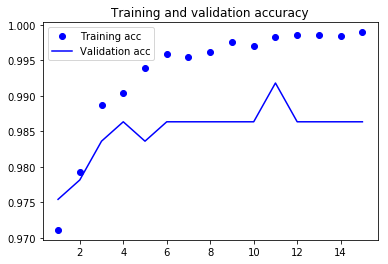

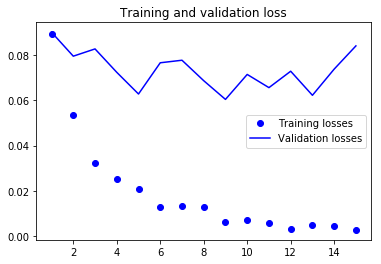

In [8]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()